<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Filtering-dataset" data-toc-modified-id="Filtering-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Filtering dataset</a></span></li><li><span><a href="#Checks" data-toc-modified-id="Checks-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Checks</a></span></li><li><span><a href="#Subsampling-tree" data-toc-modified-id="Subsampling-tree-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Subsampling tree</a></span></li><li><span><a href="#Creating-datasets" data-toc-modified-id="Creating-datasets-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Creating datasets</a></span></li><li><span><a href="#parafit:-global-test" data-toc-modified-id="parafit:-global-test-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>parafit: global test</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Summarizing</a></span></li></ul></li><li><span><a href="#parafit:-individual-links" data-toc-modified-id="parafit:-individual-links-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>parafit: individual links</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Summarizing</a></span></li><li><span><a href="#Links-per-host" data-toc-modified-id="Links-per-host-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Links per host</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* parafit analysis to support PACo results

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# misc
threads = 12
my_seed = 8394

# Init

In [4]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)

library(phyloseq)
library(ape)
library(ggpubr)

library(LeyLabRMisc)

In [5]:
clustermq_setup() 
library(clustermq)

Loading required package: clustermq

Warning message:
“package ‘clustermq’ was built under R version 3.6.3”


In [6]:
df.dims()
make_dir(work_dir)
set.seed(my_seed)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo/ 


In [7]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

# Load

In [8]:
# phyloseq
physeq_arch_IndD = readRDS(physeq_arch_IndD_file)
physeq_arch_IndD

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1345 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 1345 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1345 tips and 1342 internal nodes ]

In [9]:
# host tree
host_tree_IndD = read.tree(host_tree_IndD_file)
host_tree_IndD


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

# Filtering dataset

In [10]:
# filtering
physeq_arch_IndD = physeq_arch_IndD %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.)>0, .)
physeq_arch_IndD

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 355 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 355 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 355 tips and 354 internal nodes ]

In [11]:
# metadata
metadata = physeq_arch_IndD %>%
    phyloseq2df(sample_data) %>%
    dplyr::select(SampleID, scientific_name) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
metadata[sample_names(physeq_arch_IndD),]
metadata

,SampleID,scientific_name
,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,Abramis_brama
F35_Red_Deer,F35_Red_Deer,Cervus_elaphus
⋮,⋮,⋮
X431_Quagga,X431_Quagga,Equus_quagga
X67_European_Roe,X67_European_Roe,Capreolus_capreolus


,SampleID,scientific_name
,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,Abramis_brama
F35_Red_Deer,F35_Red_Deer,Cervus_elaphus
⋮,⋮,⋮
X431_Quagga,X431_Quagga,Equus_quagga
X67_European_Roe,X67_European_Roe,Capreolus_capreolus


# Checks

In [12]:
overlap(sample_names(physeq_arch_IndD), host_tree_IndD$tip.label)

intersect(x,y): 185 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 185 


# Subsampling tree

* multiple subsamples: one sample per species

In [11]:
# number of subsampled trees
ntrees = 100

In [12]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [13]:
# subsampling trees
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:ntrees), 
                          function(x) tree_subsample(x, df, host_tree_IndD),
                          .parallel=TRUE)

# tree lengths
host_tree_l %>% length %>% print
lapply(host_tree_l, function(x) x$tip.label %>% length) %>% unlist %>% summary

[1] 100


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    110     110     110     110     110     110 

In [14]:
# checking overlap of labels
setdiff(host_tree_l[[1]]$tip.label, rownames(metadata)) %>% length %>% print

[1] 0


# Creating datasets

In [15]:
make_parafit_input = function(host_tree, physeq){
    # subsampled phyloseq object
    physeq_f = prune_samples(sample_names(physeq) %in% host_tree$tip.label, 
                             physeq) 

    # microbial tree distance matrix
    micro_D = physeq_f %>%
        phy_tree %>% cophenetic %>% 
        rescale_dist_mtx %>% as.matrix
    # host tree distance matrix
    host_D = host_tree %>% cophenetic %>% 
             rescale_dist_mtx %>% as.matrix
    
    # otu pres/abs matrix
    otu = physeq_f %>% 
        otu_table %>%
        as.data.frame %>%
        as.matrix %>%
        t %>%
        apply(2, function(x) ifelse(x > 0, 1, 0)) %>% 
        as.matrix                
              
              
    # checking overlap
    x = length(intersect(rownames(otu), rownames(host_D)))
    y = length(union(rownames(otu), rownames(host_D)))
    stopifnot(x == y)
              
    # preparing paco data
    return(list(host.D=host_D, para.D = micro_D, HP=otu))
}

In [16]:
# creating list of parafit input objects
doParallel::registerDoParallel(threads)
PF_l = plyr::llply(host_tree_l, make_parafit_input, physeq=physeq_arch_IndD, .parallel=TRUE)
PF_l %>% length

[1] 100

# parafit: global test

In [33]:
# Function for running parafit on each dataset subsample
parafit_each = function(L, nperm=99, seed=3843, correction="cailliez", test.links=TRUE){
    parafit(L$host.D, L$para.D, L$HP, 
            nperm=nperm, 
            seed=seed,
            correction=correction,
            test.links=test.links)
}

## debug (WARNING: Slow)
#res = lapply(PF_l, parafit_each, nperm=9, test.links=FALSE)

In [34]:
# cluster job submission
tmpl = list(job_time = '00:59:00', job_mem = '10G', 
            conda = '/ebio/abt3_projects/Georg_animal_feces/envs/phyloseq',
            log_file = clustermq_logfile())  
params = list(nperm = 999, test.links = FALSE)
PF_res_l = Q(parafit_each, PF_l, const=params, pkgs=c('ape'),
             n_jobs=100, job_size=1, template=tmpl)

Setting logfile dir: /ebio/abt3_scratch//nyoungblut/clustermq/d9d3e32e-8621-4c03-bf01-03cd3d8a590d

Submitting 100 worker jobs (ID: cmq7059) ...

Running 100 calculations (2 objs/0 Mb common; 1 calls/chunk) ...


[--------------------------------------------------]   0% (1/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (2/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (3/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (4/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (5/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (6/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (7/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (8/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (9/100 wrk) eta:  ?s

[-------------------------------------------------]   0% (10/100 wr


[======>------------------------------------------]  15% (86/100 wrk) eta:  4m

[=======>------------------------------------------]  15% (86/99 wrk) eta:  4m

[=======>------------------------------------------]  16% (85/98 wrk) eta:  4m

[=======>------------------------------------------]  17% (84/97 wrk) eta:  4m

[========>-----------------------------------------]  18% (83/96 wrk) eta:  3m

[=========>----------------------------------------]  19% (82/95 wrk) eta:  3m

[=========>----------------------------------------]  20% (82/95 wrk) eta:  3m

[=========>----------------------------------------]  21% (80/93 wrk) eta:  3m

[==========>---------------------------------------]  22% (79/92 wrk) eta:  3m

[===========>--------------------------------------]  23% (78/91 wrk) eta:  3m

[===========>--------------------------------------]  24% (77/90 wrk) eta:  3m

[===========>--------------------------------------]  25% (76/89 wrk) eta:  2m

[============>-------------------------

In [36]:
# # Running on cluster
# ## cluster resources
# resources = list(h_rt = '00:59:00',
#                  h_vmem = '12G',
#                  threads = '1',
#                  conda.env = '/ebio/abt3_projects/Georg_animal_feces/envs/phyloseq', 
#                  conda.path = '/ebio/abt3_projects/software/miniconda3_gt4.4/bin')
# plan(batchtools_sge, resources=resources, workers=100)
# ## job submission
# PF_res_l = future_lapply(PF_l, parafit_each, 
#                          nperm=9, 
#                          test.links=FALSE,
#                          future.packages=c('ape'))

In [37]:
# results
PF_res_l %>% length

[1] 100

## Saving results

In [38]:
# for loading results instead of re-running
PF_file = file.path(work_dir, 'physeq_IndD-sens_parafit.RDS')
PF_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo//physeq_IndD-sens_parafit.RDS"

In [39]:
# saving
saveRDS(PF_res_l, file=PF_file)
cat('File written:', PF_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo//physeq_IndD-sens_parafit.RDS 


In [40]:
# re-loading
PF_res_l = readRDS(PF_file)
PF_res_l %>% length

[1] 100

In [41]:
send_email('http://127.0.0.1:9805/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/04_cophylo/03_parafit_rarefy.ipynb')

Sending email to: nyoungblut@tuebingen.mpg.de



## Summarizing

In [43]:
# distribution of effect size
lapply(PF_res_l, function(x) x$ParaFitGlobal) %>% unlist %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  226.1   473.3   625.0   645.1   759.0  1614.2 


In [44]:
# distribution of p-values
lapply(PF_res_l, function(x) x$p.global) %>% unlist %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00100 0.00100 0.00100 0.00106 0.00100 0.00500 


# parafit: individual links

In [47]:
parafit_each = function(L, nperm=99, seed=3843, correction="cailliez", test.links=TRUE){
    parafit(L$host.D, L$para.D, L$HP, 
            nperm=nperm, 
            seed=seed,
            correction=correction,
            test.links=test.links)
}

In [ ]:
# # cluster jobs
# ## cluster resources
# resources = list(h_rt = '200:00:00',
#                  h_vmem = '10G',
#                  threads = '1',
#                  conda.env = 'py3_physeq_eco', 
#                  conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
# plan(batchtools_sge, resources=resources, workers=100)
# ## submission
# PF_res_links_l = future_lapply(PF_l, parafit_each, 
#                          nperm=999, 
#                          test.links=TRUE,
#                          future.packages=c('ape'))

In [50]:
# cluster job submission
tmpl = list(job_time = '72:00:00', job_mem = '10G', 
            conda = '/ebio/abt3_projects/Georg_animal_feces/envs/phyloseq',
            log_file = clustermq_logfile())  
params = list(nperm = 999, test.links = TRUE)
PF_res_links_l = Q(parafit_each, PF_l, const=params, pkgs=c('ape'),
             n_jobs=100, job_size=1, template=tmpl)

Setting logfile dir: /ebio/abt3_scratch//nyoungblut/clustermq/7f81b199-061b-4964-bc03-310dfc25d88f

Submitting 100 worker jobs (ID: cmq6529) ...

Running 100 calculations (2 objs/0 Mb common; 1 calls/chunk) ...


[--------------------------------------------------]   0% (1/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (2/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (3/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (4/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (5/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (6/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (7/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (8/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (9/100 wrk) eta:  ?s

[-------------------------------------------------]   0% (10/100 wr


[------------------------------------------------]   1% (100/100 wrk) eta: 16d

[>-------------------------------------------------]   2% (99/99 wrk) eta:  9d

[=>------------------------------------------------]   3% (98/98 wrk) eta:  6d

[=>------------------------------------------------]   4% (97/97 wrk) eta:  5d

[=>------------------------------------------------]   5% (96/96 wrk) eta:  4d

[==>-----------------------------------------------]   6% (95/95 wrk) eta:  3d

[===>----------------------------------------------]   7% (94/94 wrk) eta:  3d

[===>----------------------------------------------]   8% (93/93 wrk) eta:  2d

[===>----------------------------------------------]   9% (92/92 wrk) eta:  2d

[====>---------------------------------------------]  10% (91/91 wrk) eta:  2d

[=====>--------------------------------------------]  11% (90/90 wrk) eta:  2d

[=====>--------------------------------------------]  12% (89/89 wrk) eta:  2d

[=====>--------------------------------

In [56]:
PF_res_links_l = PF_res_l 

In [57]:
# results
PF_res_links_l %>% length

[1] 100

## Saving results

In [13]:
# for loading results instead of re-running
PF_file = file.path(work_dir, 'physeq_IndD-sens_parafit-links.RDS')
PF_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo//physeq_IndD-sens_parafit-links.RDS"

In [59]:
# saving
saveRDS(PF_res_links_l, file=PF_file)
cat('File written:', PF_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/cophylo//physeq_IndD-sens_parafit-links.RDS 


In [14]:
# re-loading
PF_res_links_l = readRDS(PF_file)
PF_res_links_l %>% length

[1] 100

In [ ]:
send_email('http://127.0.0.1:9805/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/04_cophylo/03_parafit_rarefy.ipynb')

## Summarizing

In [15]:
# distribution of effect size
lapply(PF_res_links_l, function(x) x$ParaFitGlobal) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  226.1   473.3   625.0   645.1   759.0  1614.2 

In [16]:
# distribution of p-values
lapply(PF_res_links_l, function(x) x$p.global) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00100 0.00100 0.00100 0.00106 0.00100 0.00500 

## Links per host

In [24]:
# format
para_per_host = lapply(PF_res_links_l, function(x) x$para.per.host) %>%
    do.call(rbind, .) %>%
    as.data.frame %>%
    mutate(Dataset_rep = 1:nrow(.)) %>%
    gather(Sample, N_links, -Dataset_rep) 
               
para_per_host

Dataset_rep,Sample,N_links
<int>,<chr>,<dbl>
1,F14_Common_Bream,9
2,F14_Common_Bream,9
⋮,⋮,⋮
99,X67_European_Roe,3
100,X67_European_Roe,3


In [25]:
# adding metadata
para_per_host = physeq_arch_IndD %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(SampleID, class, order, family, genus, scientific_name, diet) %>%
    inner_join(para_per_host, c('SampleID'='Sample')) 

para_per_host 

Warning message:
“Column `SampleID`/`Sample` joining factor and character vector, coercing into character vector”


SampleID,class,order,family,genus,scientific_name,diet,Dataset_rep,N_links
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>
F14_Common_Bream,Actinopterygii,Cypriniformes,Cyprinidae,Abramis,Abramis_brama,omnivore,1,9
F14_Common_Bream,Actinopterygii,Cypriniformes,Cyprinidae,Abramis,Abramis_brama,omnivore,2,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X67_European_Roe,Mammalia,Artiodactyla,Cervidae,Capreolus,Capreolus_capreolus,herbivore,99,3
X67_European_Roe,Mammalia,Artiodactyla,Cervidae,Capreolus,Capreolus_capreolus,herbivore,100,3


In [26]:
# summarizing by species: check
para_per_host %>%
    group_by(scientific_name) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    100     100     100     100     100     100 


In [27]:
# summarizing by species
alpha=0.95

para_per_host = para_per_host %>%
    group_by(scientific_name, class, order, family, genus, diet) %>%
    summarize(min_n_links = min(N_links),
              q1_n_links = quantile(N_links, 0.25),
              mean_n_links = mean(N_links),
              median_n_links = median(N_links),
              q3_n_links = quantile(N_links, 0.75),
              max_n_links = max(N_links),
              sd_n_links = sd(N_links),
              CI_low = quantile(N_links, (1-alpha)/2),
              CI_high = quantile(N_links, alpha+((1-alpha)/2))) %>%
    ungroup() %>%
    mutate(scientific_name = scientific_name %>% reorder(-median_n_links))

para_per_host$CI_low %>% summary %>% print
para_per_host 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   4.679   6.987  15.000 


scientific_name,class,order,family,genus,diet,min_n_links,q1_n_links,mean_n_links,median_n_links,q3_n_links,max_n_links,sd_n_links,CI_low,CI_high
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abramis_brama,Actinopterygii,Cypriniformes,Cyprinidae,Abramis,omnivore,9,9,9.00,9.0,9,9,0.000000,9,9
Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore,3,10,12.84,10.5,13,28,6.167232,6,28
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vulpes_vulpes,Mammalia,Carnivora,Canidae,Vulpes,omnivore,9,9,12.24,10,19,20,4.564067,9,20
Zamenis_longissimus,Reptilia,Squamata,Colubridae,Zamenis,carnivore,2,6,12.80,12,16,24,7.305733,2,24


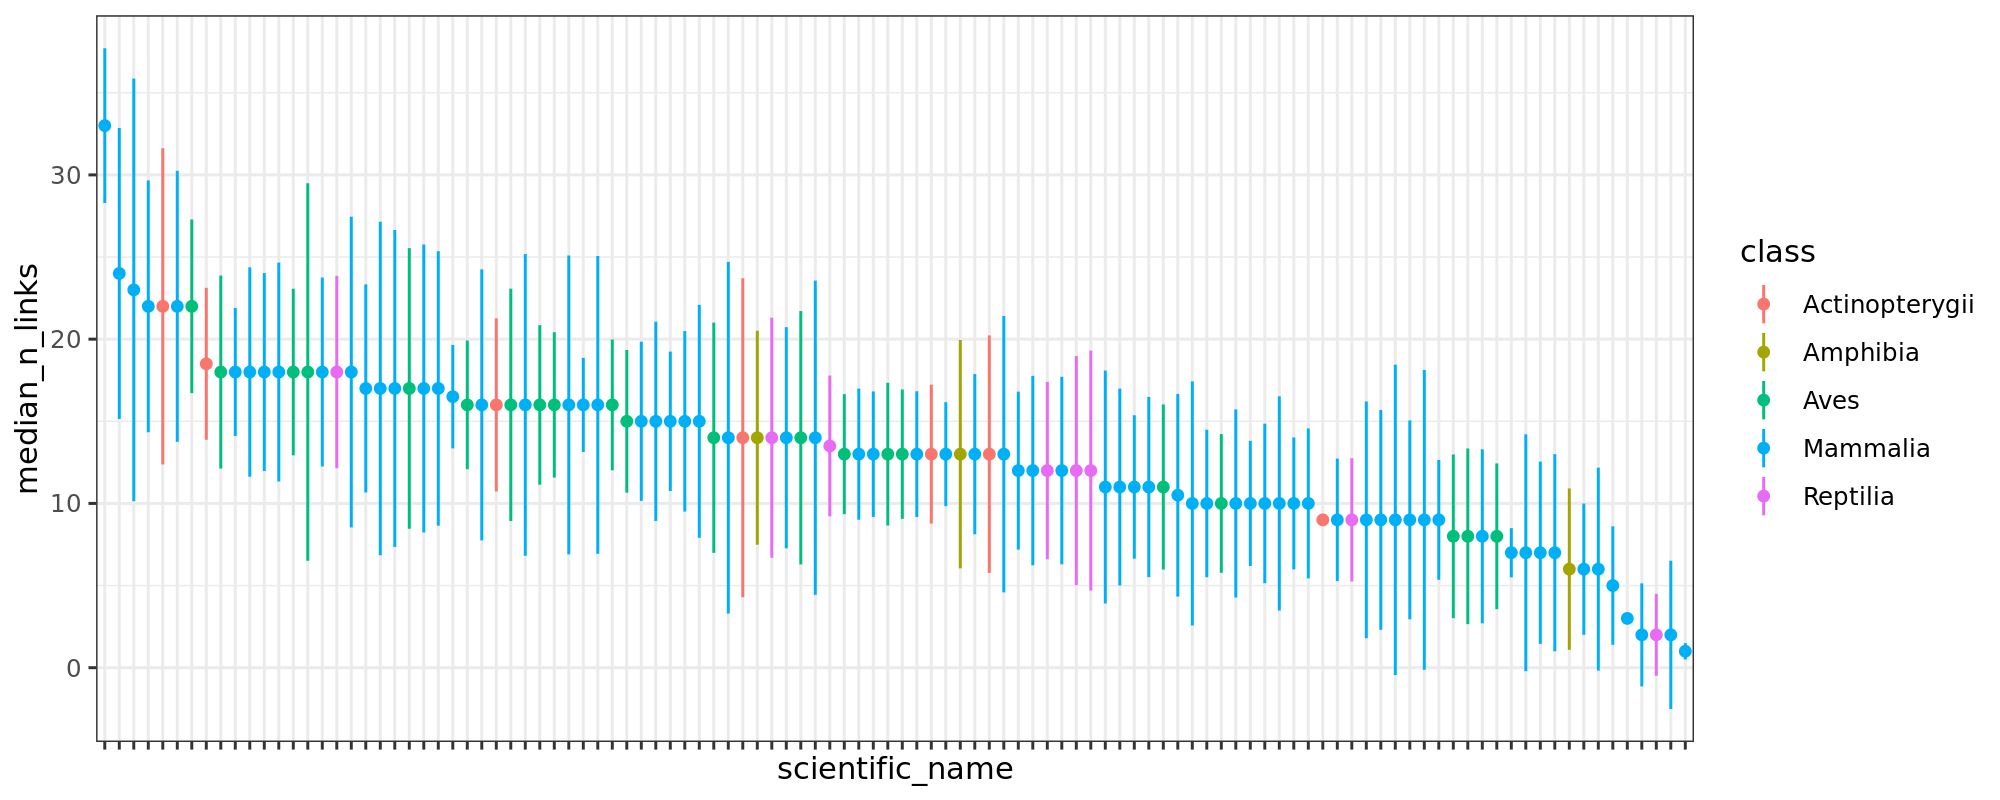

In [28]:
# plotting distribution
p = ggplot(para_per_host, aes(scientific_name, median_n_links, color=class)) +
    geom_linerange(aes(ymin=median_n_links-sd_n_links,
                       ymax=median_n_links+sd_n_links)) +
    geom_point() +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )

p.dims(10,4)
plot(p)

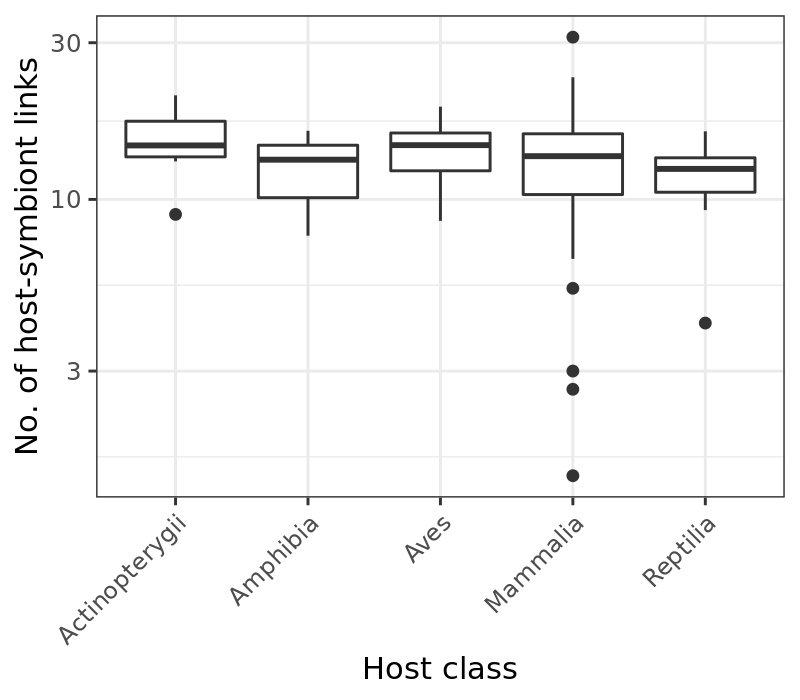

In [29]:
# plotting distribution
p = para_per_host %>%
    ggplot(aes(class, mean_n_links)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(x='Host class', y='No. of host-symbiont links') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(4,3.5)
plot(p)

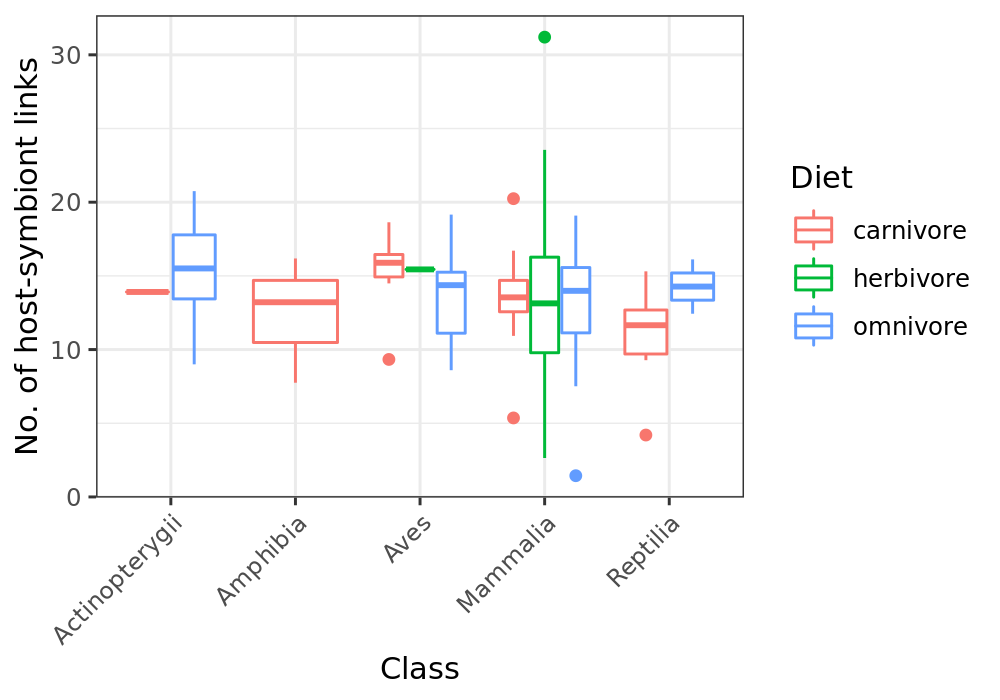

In [34]:
# plotting distribution
p = para_per_host %>%
    ggplot(aes(class, mean_n_links, color=diet)) +
    geom_boxplot() +
    scale_color_discrete('Diet') +
    labs(x='Class', y='No. of host-symbiont links') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(5,3.5)
plot(p)

In [32]:
# anova
aov_res = car::Anova(lm(mean_n_links ~ class + diet, data=para_per_host), type=2)
aov_res 

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
class,60.5342763,4,0.765170450,0.5502969
diet,0.3157129,2,0.007981401,0.9920510
Residuals,2037.1377558,103,NA,NA


# sessionInfo

In [80]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] uuid_0.1-4         clustermq_0.8.95.1 LeyLabRMisc_0.1.6  ape_5.4           
 [5] phyloseq_1.30.0    tidytable_0.4.1    data.table_1.12.8  ggplot2_3.3.1     
 [9] tidyr_1.1.0        dplyr_1.0.0       

loaded via a namespace (and not attached):
 [1] Biobase_2.46.0      jsonlite_